In [11]:
## Imports
import numpy as np 
import scipy.io.wavfile as wav
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt

### 3. 1 Preprocessing for Eigenface Computation

In [27]:

image = Image.open('data/faces/Aaron_Eckhart_0001.pgm')
nrows, ncolumns = 64, 64
def load_images(imagedirectory):
    image_list = []
    for i, imagefile in enumerate(os.listdir(imagedirectory)):
        image = Image.open(os.path.join(imagedirectory, imagefile))
        image = image.resize((nrows, ncolumns))
        image_list.append(np.asarray(image.getdata()))
    return image_list

X = np.asarray(load_images('yalefaces'))

#### Compute the eigen faces and plot first eigen face

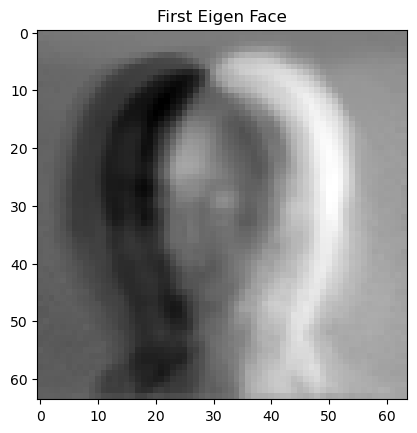

In [28]:
mean_image = np.sum(X, axis=0, dtype='float64')/X.shape[0] ## Get Mean of images
mean_matrix = np.tile(mean_image, (X.shape[0], 1))  ## place holder of mean of images (for faster computation)
X_centered = X - mean_matrix  ## mean centering
L = (X_centered.dot(X_centered.T))/X.shape[0]  ## Calculate covariance matrix and normalize it
eigenvalues, eigenvectors = np.linalg.eig(L)  ## Get eigen values and eigen vectors of images
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)
idx = eigenvalues.argsort()[::-1] ## sort the eigen values 
eigenvalues = eigenvalues[idx] ## reorder the eigen vectors
eigenvectors_C = eigenvectors[:, idx] ## Get the pricipal componenets
eigenvectors_C = X_centered.T @ eigenvectors  ## project all images to the eigen space
eigen_faces = preprocessing.normalize(eigenvectors_C.T) ## normalize all eigen faces
plt.imshow(np.resize(eigen_faces[0], (nrows,ncolumns)), cmap='gray')  # plot the first eigen face
plt.title('First Eigen Face')
plt.show()

#### 3.2 2. Reconstruction Error.

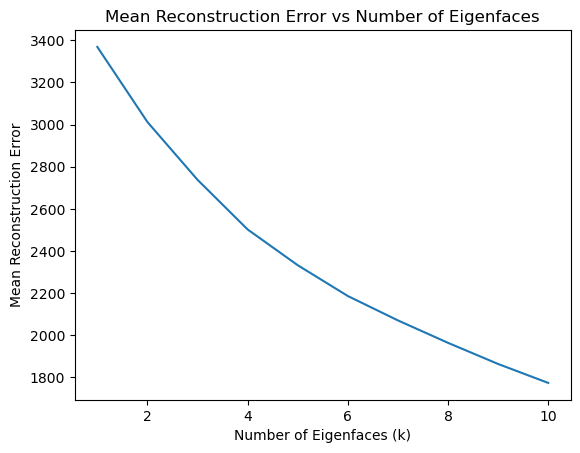

Mean reconstruction error using k=10: 1773.56261683575


In [29]:
errors = []

for k in range(1, 11):  # We'll compute for k from 1 to 10
    error_sum = 0
    for F in X:
        omega = eigen_faces[:k].dot(F - mean_image)
        F_reconstructed = eigen_faces[:k].T.dot(omega) + mean_image
        error = np.linalg.norm(F - F_reconstructed)
        error_sum += error
    mean_error = error_sum / X.shape[0]
    errors.append(mean_error)

plt.plot(range(1, 11), errors)
plt.xlabel('Number of Eigenfaces (k)')
plt.ylabel('Mean Reconstruction Error')
plt.title('Mean Reconstruction Error vs Number of Eigenfaces')
plt.show()

print(f"Mean reconstruction error using k=10: {errors[9]}")

In [30]:
def project_to_eigenspace(image, eigen_faces, mean_image):
    return eigen_faces.dot(image - mean_image)


In [31]:
def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)


In [32]:
def compute_max_similarity(image_projection, eigen_faces, num_components):
    eigen_projections = [project_to_eigenspace(ef, eigen_faces, mean_image) for ef in eigen_faces[:num_components]]
    similarities = [cosine_similarity(image_projection, ep) for ep in eigen_projections]
    
    return np.max(similarities)


In [33]:
def is_face(image, eigen_faces, mean_image,num_components, threshold=0.5):
    image_projection = project_to_eigenspace(image, eigen_faces, mean_image)
    max_similarity = compute_max_similarity(image_projection, eigen_faces[:num_components],num_components)
    return max_similarity > threshold

In [57]:
# given_image = Image.open('data/faces/Ariel_Sharon_0042.pgm') # sample face
given_image = Image.open('non_faces/B1_00002.pgm') # sample non face
given_image = given_image.resize((64,64))
num_components = 25
given_image = np.asarray(given_image.getdata())
result = is_face(given_image, eigen_faces[:num_components],mean_image, num_components)
print("The image is a face!" if result else "The image is not a face!")
true_label = []
predicted_label = []
## To do loop through non faces and faces 
for i, imagefile in enumerate(os.listdir('yalefaces/')):
    true_label.append(1)
    new_image = Image.open(os.path.join('yalefaces/', imagefile))
    new_image = new_image.resize((64,64))
    new_image = np.asarray(new_image.getdata())
    if is_face(new_image, eigen_faces[:num_components], mean_image,num_components):
        predicted_label.append(1)
    else:
        predicted_label.append(0)

## To do loop through non faces and faces 
for i, imagefile in enumerate(os.listdir('non_faces/')):
    true_label.append(0)
    new_image = Image.open(os.path.join('non_faces/', imagefile))
    new_image = new_image.resize((64,64))
    new_image = np.asarray(new_image.getdata())
    if is_face(new_image, eigen_faces[:num_components], mean_image, num_components):
        predicted_label.append(1)
        
    else:
        predicted_label.append(0)

The image is a face!


In [58]:
from sklearn.metrics import accuracy_score
accuracy_score(true_label, predicted_label)

0.09580838323353294